In [1]:
pip install accelerate bertopic matplotlib jupyter-dash sentence_transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 18.1 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 38.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 27.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41

In [2]:
from huggingface_hub import notebook_login

In [3]:
notebook_login()

In [28]:
from datasets import load_dataset, Dataset

In [29]:
import torch 
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [30]:
embedded_ds = load_dataset("mwarchalowski/grants", "no-shorts-no-dups")
embedded_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 126778
    })
})

In [31]:
labeled_ds = load_dataset("mwarchalowski/grants", "labeled_subset")

In [32]:
dataset = embedded_ds

In [33]:
embedding_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

In [34]:
umap_model = UMAP(n_neighbors=10, n_components=8, min_dist=0.0, metric='cosine', random_state=42)
umap_model

UMAP(metric='cosine', min_dist=0.0, n_components=8, n_neighbors=10, random_state=42)

In [35]:
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model

HDBSCAN(min_cluster_size=50, prediction_data=True)

In [36]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
vectorizer_model

CountVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english')

In [37]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  top_n_words=30,
  verbose=True
)


In [38]:
splits = dataset["train"].train_test_split(test_size=0.1)
splits

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 114100
    })
    test: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 12678
    })
})

In [39]:
embeddings = [np.array(json.loads(x)) for x in splits["train"]["tensors"]]

In [40]:
embeddings = np.array(embeddings)
embeddings

array([[ 0.42324415,  0.85174531, -0.68597132, ..., -0.54126376,
         0.37831652, -0.49681383],
       [-0.33950317, -0.32339936, -0.31536433, ..., -0.43165553,
        -0.0624863 ,  0.72297937],
       [ 0.27692237,  0.59825855, -0.59869111, ..., -0.36654633,
         0.89923453, -0.32795256],
       ...,
       [-0.53511292, -0.04949236,  0.0658411 , ...,  0.02149285,
         0.08155347, -0.3061386 ],
       [ 0.21701103,  0.30435082,  0.45969352, ..., -0.5326587 ,
        -0.13885389, -0.21074171],
       [ 0.51023841,  0.10621642, -0.08726075, ...,  0.62837893,
         0.00980941,  0.31675267]])

In [41]:
topics, probs = topic_model.fit_transform(splits["train"]["abstr"], embeddings)

2024-04-13 00:45:35,132 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-13 00:46:35,326 - BERTopic - Dimensionality - Completed ✓
2024-04-13 00:46:35,328 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

In [42]:
pd.set_option('display.max_colwidth', None)
topic_model.get_topic_info()[["Count", "Representation"]][:25]


Count  \
0   57411   
1    3913   
2    1750   
3    1655   
4    1065   
5    1009   
6     994   
7     862   
8     830   
9     817   
10    799   
11    763   
12    759   
13    707   
14    649   
15    619   
16    566   
17    538   
18    527   
19    525   
20    512   
21    504   
22    475   
23    462   
24    460   

                                                                                                                                                                                                                                                                                                                                           Representation  
0                                                                                                                             [research, project, data, new, cancer, cells, study, development, based, use, br, using, cell, high, systems, used, studies, develop, gt, lt, lt br, br gt, time, provide, health, different, model, human, patients, work]  
1                                                                        [quantum, optical, spin, devices, materials, magnetic, laser, properties, electronic, systems, high, electron, light, photonic, physics, applications, semiconductor, device, field, phase, states, atoms, state, single, atomic, new, low, power, superconducting, temperature]  
2                                      [alloys, materials, material, mechanical, composite, process, alloy, strength, manufacturing, properties, fatigue, composites, temperature, crack, microstructure, high, corrosion, grain, phase, steels, steel, thermal, deformation, ceramic, wear, metal, components, coating, mechanical properties, fracture]  
3                                             [beta, diabetes, beta cells, islet, insulin, beta cell, t1d, cells, islets, type diabetes, cell, pancreas, pancreatic, type, mice, nod, immune, autoimmune, transplantation, insulin producing, human, mouse, diabetic, producing, glucose, nod mice, islet transplantation, blood, cell mass, destruction]  
4                                                                [imaging, breast, cancer, tumor, radiation, tissue, dose, breast cancer, ultrasound, mammography, mri, image, therapy, treatment, pet, prostate, detection, tumors, images, contrast, clinical, patient, biopsy, ray, technique, ct, diagnosis, prostate cancer, patients, radiotherapy]  
5                                                                               [mantle, seismic, rocks, crust, earth, fault, magma, tectonic, crustal, earthquake, plate, magmatic, rock, earthquakes, subduction, fluid, deformation, volcanic, mineral, continental, geological, evolution, minerals, deposits, br, zone, data, melt, lithosphere, lt]  
6                                                                                  [plant, plants, arabidopsis, genes, crop, gene, auxin, wheat, genetic, molecular, root, proteins, resistance, seed, protein, breeding, stress, crops, growth, cell, mutants, expression, pathogen, thaliana, barley, genome, species, chloroplast, regulation, pollen]  
7                            [synthesis, reactions, chemistry, chiral, reaction, metal, complexes, compounds, organic, synthetic, catalysts, catalysis, asymmetric, catalytic, molecules, reactivity, ligands, bond, chemical, new, transition metal, ring, group, bonds, transition, enantioselective, intermediates, reagents, radical, organometallic]  
8                                                    [organic, solar, solar cells, electronic, materials, molecular, charge, devices, perovskite, properties, molecules, light, metal, energy, chemistry, electron, efficiency, chemical, conjugated, photovoltaic, films, solar cell, polymers, transfer, pv, silicon, film, quantum, structure, device]  
9                         [prostate, prostate cancer, cancer, androgen, ar, tumor, men, pca, cells, cancer cells, progression, androgen receptor, therapy, growth, patients, metastatic, 

In [43]:
from transformers import pipeline, AutoTokenizer
evaluator = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(evaluator)
pipe = pipeline("text-generation", model=evaluator, device_map="auto", torch_dtype=torch.bfloat16)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
def evaluate(example):
    messages = [
        {
            "role": "system",
            "content": "You are a knowledgable science expert. Given list of words, find category that the words fit into. Omit all explanations and artifacts.",
        },
        { 
            "role": "user", 
            "content": "[apple, pear, carrot, potato, banana]"
        },
        { 
            "role": "assistant", 
            "content": "Fruits and Vegetbles"
        },
        { 
            "role": "user", 
            "content": "[car, bus, passanger, ferry]"
        },
        { 
            "role": "assistant", 
            "content": "Transportation"
        },
        { 
            "role": "user", 
            "content": example["text"]
        }
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.3, top_k=20, top_p=0.45, return_full_text=False)
    return {'label': outputs[0]["generated_text"]}


In [50]:
z  =  Dataset.from_pandas(topic_model.get_topic_info()[["Representation", 'Count']][:100])
z = z.map(lambda e: {'text': "[{}]".format(", ".join(e['Representation']))})
x = z.map(evaluate)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [46]:
x.with_format("pandas")[:][['Count','Representation', 'label']]

Count  \
0     296   
1     295   
2     289   
3     288   
4     282   
5     282   
6     277   
7     276   
8     272   
9     270   
10    270   
11    266   
12    266   
13    261   
14    256   
15    255   
16    253   
17    252   
18    250   
19    245   
20    244   
21    233   
22    230   
23    225   
24    223   
25    222   
26    216   
27    215   
28    213   
29    207   
30    205   
31    203   
32    203   
33    203   
34    197   
35    194   
36    192   
37    191   
38    191   
39    191   
40    190   
41    188   
42    187   
43    185   
44    184   
45    183   
46    178   
47    178   
48    176   
49    176   

                                                                                                                                                                                                                                                                                                                                                                            Representation  \
0                                                  [ibd, intestinal, gut, microbiota, microbiome, colitis, bowel, inflammatory, bacteria, inflammatory bowel, disease, crohn, inflammation, crohn disease, immune, bowel disease, mucosal, microbes, epithelial, intestine, microbial, bacterial, disease ibd, diseases, colon, gut microbiota, patients, cd, uc, intestinal inflammation]   
1                                                                           [rna, mrna, ribosome, trna, rnas, proteins, protein, translation, transcription, splicing, ribosomal, mrnas, ribosomes, gene, binding, regulation, gene expression, genes, expression, rrna, function, trnas, protein synthesis, messenger, complex, polymerase, factors, rna polymerase, editing, regulatory]   
2                                                                         [parasite, malaria, parasites, falciparum, plasmodium, infection, antigens, host, vaccine, leishmania, drug, leishmaniasis, infected, mosquito, vivax, brucei, endemic, drugs, immune, disease, parasitic, gondii, human, mosquitoes, trypanosomes, resistance, protective, proteins, vaccines, schistosomiasis]   
3                                                                                           [sperm, gnrh, egg, oocyte, embryo, embryos, fsh, fertility, fertilization, pituitary, reproductive, lh, oocytes, granulosa, follicle, follicles, maturation, gonadotropin, ovarian, ovulation, follicular, infertility, ovary, activin, hormone, expression, male, testis, reproduction, cell]   
4                                                                                         [brca1, dna, repair, brca2, dna damage, breast, damage, cancer, dna repair, mutations, breast cancer, checkpoint, cells, proteins, replication, cell, protein, instability, genes, yeast, spindle, gene, chromosomes, cancers, cell cycle, brca1 brca2, dna replication, genetic, tumor, normal]   
5                                                 [cancer, women, breast cancer, breast, survivors, care, patients, screening, treatment, intervention, cancer survivors, quality life, cancer patients, decision, risk, health, distress, quality, life, patient, diagnosed, chemotherapy, counseling, psychological, mammography, study, outcomes, clinical, survivorship, psychosocial]   
6                                                                [operators, spaces, theory, equations, operator, br, differential, geometric, geometry, lt br, br gt, lt, gt, functions, problems, differential equations, algebras, banach, mathematical, partial differential, harmonic, analysis, partial, problem, analytic, regularity, mathematics, manifolds, spectral, classical]   
7                                                                                                [social, welfare, family, policy, education, labour, child, gender, children, fertility, labor, work, workers, policies, market, employment, economic, labour market, job, parents, social 

In [47]:
hierarchical_topics = topic_model.hierarchical_topics(splits["train"]["abstr"])


100%|██████████| 243/243 [00:04<00:00, 57.40it/s]


In [48]:
topic_model.visualize_topics()

In [49]:
topic_model.get_topic_info()

Topic  Count                                       Name  \
0       -1  57411               -1_research_project_data_new   
1        0   3913             0_quantum_optical_spin_devices   
2        1   1750     1_alloys_materials_material_mechanical   
3        2   1655           2_beta_diabetes_beta cells_islet   
4        3   1065              3_imaging_breast_cancer_tumor   
..     ...    ...                                        ...   
240    239     51     239_fouling_coatings_biofouling_marine   
241    240     51      240_ischemic_ischemia_stroke_neuronal   
242    241     51     241_snow_glacier_glaciers_mass balance   
243    242     51  242_masseter_swallowing_tongue_mandibular   
244    243     50          243_gpcrs_gpcr_receptor_receptors   

                                                                                                                                                                                                                                                                                                                             Representation  \
0                                                                                                               [research, project, data, new, cancer, cells, study, development, based, use, br, using, cell, high, systems, used, studies, develop, gt, lt, lt br, br gt, time, provide, health, different, model, human, patients, work]   
1                                                          [quantum, optical, spin, devices, materials, magnetic, laser, properties, electronic, systems, high, electron, light, photonic, physics, applications, semiconductor, device, field, phase, states, atoms, state, single, atomic, new, low, power, superconducting, temperature]   
2                        [alloys, materials, material, mechanical, composite, process, alloy, strength, manufacturing, properties, fatigue, composites, temperature, crack, microstructure, high, corrosion, grain, phase, steels, steel, thermal, deformation, ceramic, wear, metal, components, coating, mechanical properties, fracture]   
3                               [beta, diabetes, beta cells, islet, insulin, beta cell, t1d, cells, islets, type diabetes, cell, pancreas, pancreatic, type, mice, nod, immune, autoimmune, transplantation, insulin producing, human, mouse, diabetic, producing, glucose, nod mice, islet transplantation, blood, cell mass, destruction]   
4                                                  [imaging, breast, cancer, tumor, radiation, tissue, dose, breast cancer, ultrasound, mammography, mri, image, therapy, treatment, pet, prostate, detection, tumors, images, contrast, clinical, patient, biopsy, ray, technique, ct, diagnosis, prostate cancer, patients, radiotherapy]   
..                                                                                                                                                                                                                                                                                                                                      ...   
240  [fouling, coatings, biofouling, marine, antifouling, surfaces, fouling release, coating, anti fouling, surface, corrosion, settlement, anti, fouling organisms, zwitterionic, hull, fr, organisms, polymer, release, af, onr, anti biofouling, marine fouling, biofilm, properties, grooming, marine coatings, pdms, superhydrophobic]   
241                                           [ischemic, ischemia, stroke, neuronal, brain, neuronal death, death, peroxynitrite, hi, cerebral, hypothermia, neurons, nitric oxide, injury, nitric, insult, ca1, rbm3, inos, cerebral ischemia, hippocampal, oxide, gaba, astrocytes, brain damage, induced, damage, nr4a1, blood, hypoxic]   
242                                [snow, glacier, glaciers, mass balance, climate, debris, balance, mass, snow cover, mountain, precipitation, glacier mass, ice, cover, remote sensing, water, remote, melt, swe, snow dept

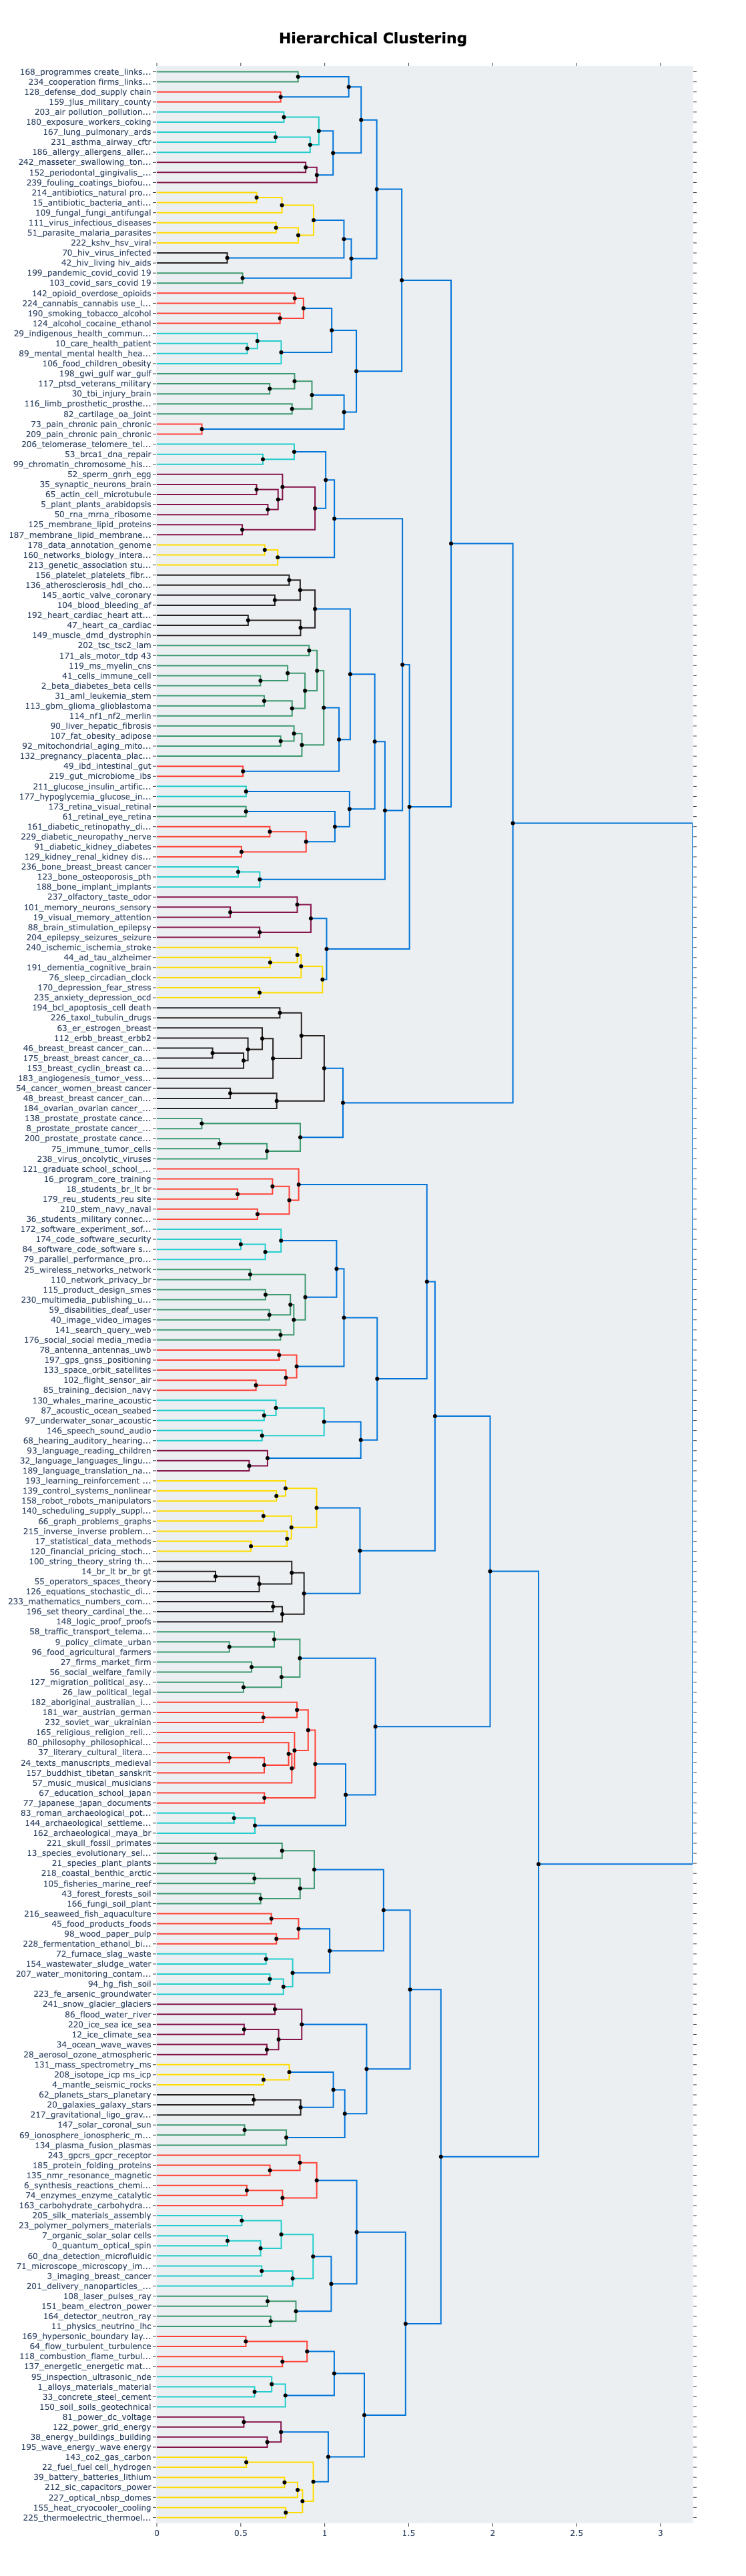

In [52]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)